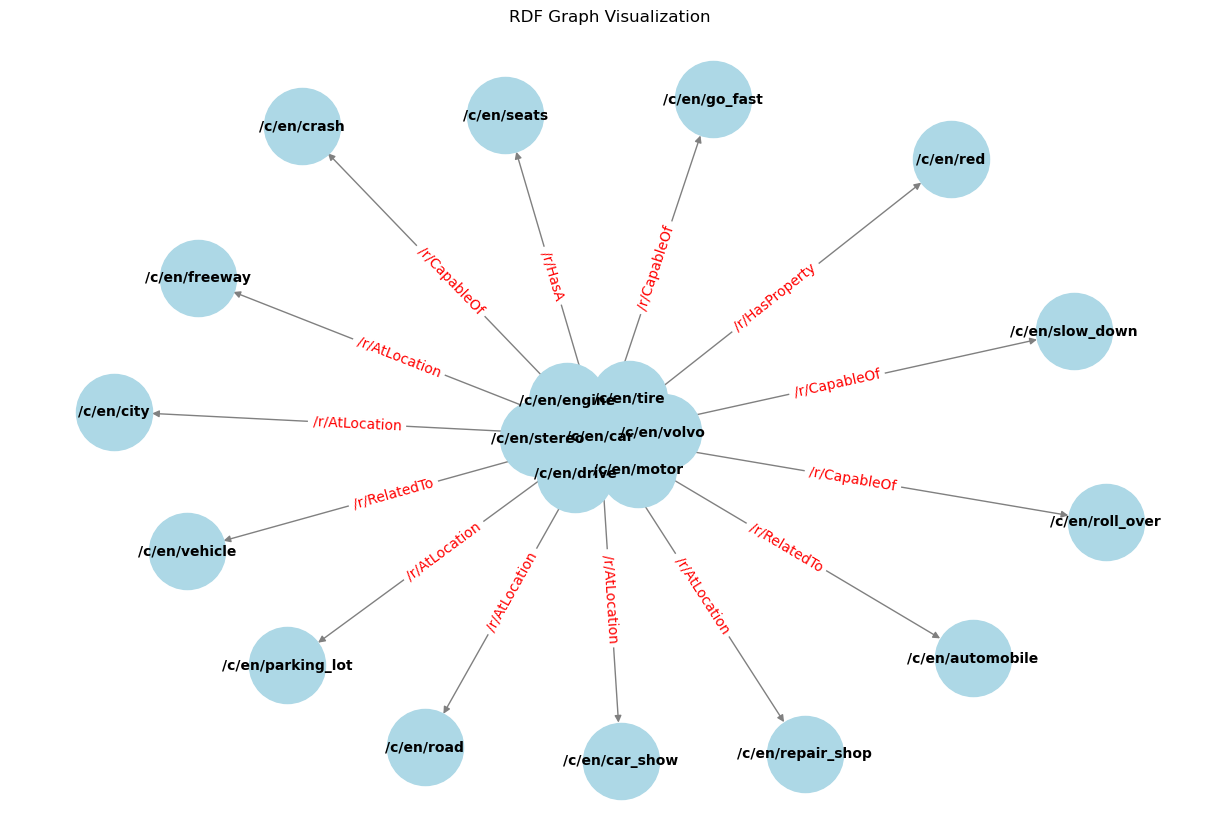

In [34]:
import requests
from rdflib import Graph, URIRef, Literal, Namespace
import networkx as nx
import matplotlib.pyplot as plt

def get_conceptnet_relationships_as_rdf(term, lang="en"):
    base_url = "http://api.conceptnet.io/"
    term_url = f"{base_url}c/{lang}/{term}"
    response = requests.get(term_url).json()
    edges = response.get('edges', [])
    g = Graph()
    CN = Namespace(base_url)
    g.bind("cn", CN)
    for edge in edges:
        start_node = URIRef(edge['start']['@id'])
        end_node = URIRef(edge['end']['@id'])
        predicate = URIRef(edge['rel']['@id'])
        g.add((start_node, predicate, end_node))
    return g

def visualize_rdf_graph(rdf_graph):
    # Convert RDF graph to a NetworkX graph
    nx_graph = nx.DiGraph()
    
    for s, p, o in rdf_graph:
        nx_graph.add_edge(str(s), str(o), label=str(p))
    
    # Draw the graph
    pos = nx.spring_layout(nx_graph)  # Spring layout for better spacing
    plt.figure(figsize=(12, 8))
    
    # Draw nodes and edges
    nx.draw(nx_graph, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", edge_color="gray")
    
    # Draw edge labels
    edge_labels = nx.get_edge_attributes(nx_graph, 'label')
    nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=edge_labels, font_color="red")
    
    plt.title("RDF Graph Visualization")
    plt.show()

# Example usage
if __name__ == "__main__":
    word = "car"
    rdf_graph = get_conceptnet_relationships_as_rdf(word)
    visualize_rdf_graph(rdf_graph)


In [51]:
import requests
import json

def fetch_raw_conceptnet_data(term, lang="en"):
    base_url = "http://api.conceptnet.io/"
    term_url = f"{base_url}c/{lang}/{term}"
    response = requests.get(term_url)
    return response.json()  # Return the raw JSON response

# Example usage
if __name__ == "__main__":
    word = "car"
    raw_data = fetch_raw_conceptnet_data(word)
    
    # Print the raw JSON data for inspection
    print(json.dumps(raw_data, indent=4))


{
    "@context": [
        "http://api.conceptnet.io/ld/conceptnet5.7/context.ld.json"
    ],
    "@id": "/c/en/car",
    "edges": [
        {
            "@id": "/a/[/r/RelatedTo/,/c/en/drive/,/c/en/car/]",
            "@type": "Edge",
            "dataset": "/d/verbosity",
            "end": {
                "@id": "/c/en/car",
                "@type": "Node",
                "label": "car",
                "language": "en",
                "term": "/c/en/car"
            },
            "license": "cc:by/4.0",
            "rel": {
                "@id": "/r/RelatedTo",
                "@type": "Relation",
                "label": "RelatedTo"
            },
            "sources": [
                {
                    "@id": "/and/[/s/process/split_words/,/s/resource/verbosity/]",
                    "@type": "Source",
                    "contributor": "/s/resource/verbosity",
                    "process": "/s/process/split_words"
                },
                {
            

In [52]:
import requests
import json

def fetch_raw_conceptnet_data(term, lang="en"):
    base_url = "http://api.conceptnet.io/"
    term_url = f"{base_url}c/{lang}/{term}"
    response = requests.get(term_url)
    return response.json()  # Return the raw JSON response

def extract_relationships(raw_data):
    relationships = []
    
    # Extract relationships from the edges in the raw data
    if "edges" in raw_data:
        for edge in raw_data["edges"]:
            start_node = edge['start']['label']  # Start concept label
            relation = edge['rel']['label']  # Relation type
            end_node = edge['end']['label']  # End concept label
            relationships.append(f"{start_node} -> {relation} -> {end_node}")
    
    return relationships

# Example usage
if __name__ == "__main__":
    word = "car"
    raw_data = fetch_raw_conceptnet_data(word)
    
    # Extract and print relationships
    relationships = extract_relationships(raw_data)
    
    if relationships:
        print(f"Relationships for '{word}':")
        for rel in relationships:
            print(rel)
    else:
        print(f"No relationships found for '{word}'.")


Relationships for 'car':
drive -> RelatedTo -> car
a car -> AtLocation -> the city
a car -> AtLocation -> a parking lot
car -> RelatedTo -> vehicle
A car -> CapableOf -> go fast
a car -> CapableOf -> crash
a car -> HasA -> seats
a car -> AtLocation -> the repair shop
A car -> CapableOf -> roll over
motor -> RelatedTo -> car
car -> RelatedTo -> automobile
a car -> CapableOf -> slow down
A tire -> PartOf -> a car
a car -> AtLocation -> the road
A volvo -> IsA -> car
stereo -> AtLocation -> a car
car -> AtLocation -> a freeway
car -> AtLocation -> a car show
my car -> HasProperty -> red
An engine  -> PartOf -> a car 
